# Классификация текстов
# Домашнее задание — мультиклассовая классификация по вопросам о языках программирования на Stack Overflow

В новой задаче используется датасет с несколькими тысячами вопросов по четырём языкам программирования со Stack Overflow. Он извлечён из датасета [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow) с более чем 17 миллионами вопросов.

Все упоминания целевых языков программирования в данных заменены на *blank*.

Необходимо внести в учебный блокнот по классификации данных с IMDB следующие изменения:

- Скачать новый подготовленный набор данных (датасет): [Stack Overflow dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) (адрес: https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz).

Структура файлов  в архиве с данными:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Изменить части кода, отвечающие новой задаче классификации, которая теперь мультиклассовая:

- Заменить размерность последнего полносвязного слоя для нового количества предсказываемых классов.

- Использовать функцию потерь, подходящую для целочисленных меток классов: `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`. Метрика должна иметь значение `metrics=['accuracy']` (`tf.metrics.BinaryAccuracy` только для бинарной классификации.

- При построении графиков скорректируйте метрики на те, которые реально используются вами в решении.


# Для основы возьмите бинарный случай классификации, который был разобран на уроке.

In [2]:
pip install tensorflow

                                              0.0/284.2 MB ? eta -:--:--
                                              0.1/284.2 MB 1.8 MB/s eta 0:02:40
                                              0.3/284.2 MB 3.3 MB/s eta 0:01:26
                                              0.6/284.2 MB 4.5 MB/s eta 0:01:03
                                              0.9/284.2 MB 4.5 MB/s eta 0:01:03
                                              1.3/284.2 MB 5.7 MB/s eta 0:00:50
                                              1.8/284.2 MB 6.7 MB/s eta 0:00:42
                                              2.2/284.2 MB 6.7 MB/s eta 0:00:42
                                              3.1/284.2 MB 8.2 MB/s eta 0:00:35
                                              4.0/284.2 MB 9.5 MB/s eta 0:00:30
                                             5.0/284.2 MB 10.6 MB/s eta 0:00:27
                                             6.0/284.2 MB 11.6 MB/s eta 0:00:25
                                             7.


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Epoch 1/10
200/200 [==============================] - 6s 28ms/step - loss: 1.3775 - accuracy: 0.3509 - val_loss: 1.3668 - val_accuracy: 0.5000
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 1.3504 - accuracy: 0.4648 - val_loss: 1.3314 - val_accuracy: 0.5300
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 1.3035 - accuracy: 0.5273 - val_loss: 1.2756 - val_accuracy: 0.5731
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 1.2384 - accuracy: 0.5722 - val_loss: 1.2064 - val_accuracy: 0.6256
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 1.1630 - accuracy: 0.6288 - val_loss: 1.1324 - val_accuracy: 0.6719
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 1.0855 - accuracy: 0.6797 - val_loss: 1.0600 - val_accuracy: 0.6975
E

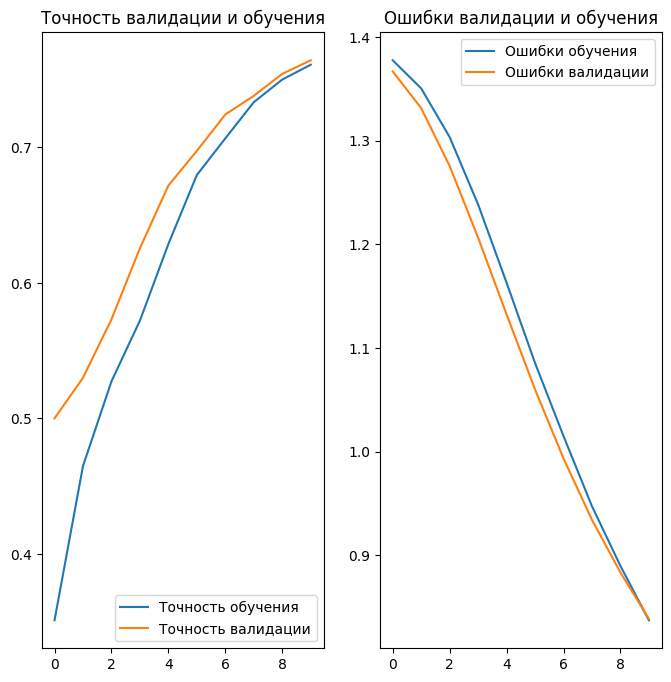

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import matplotlib.pyplot as plt

import os
import re
import string

AUTOTUNE = tf.data.AUTOTUNE

# Загрузка данных
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
dataset = tf.keras.utils.get_file("stack_overflow_16k.tar.gz", url, untar=True, cache_dir='.', cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow_16k')

# Подготовка данных
batch_size = 32
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=42)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=42)

# Препроцессинг текста
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

# Применение функции к датасетам
train_ds = raw_train_ds.map(vectorize_text)
validation_ds = raw_val_ds.map(vectorize_text)

# Конфигурация датасета для производительности
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Построение модели
num_classes = 4

model = keras.Sequential([
  layers.Embedding(max_features + 1, 16),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

# Компиляция модели
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

# Обучение модели
epochs = 10
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs)

train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy, label='Точность обучения')
plt.plot(epochs_range, validation_accuracy, label='Точность валидации')
plt.legend(loc='lower right')
plt.title('Точность валидации и обучения')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Ошибки обучения')
plt.plot(epochs_range, validation_loss, label='Ошибки валидации')
plt.legend(loc='upper right')
plt.title('Ошибки валидации и обучения')

plt.show()